# The tf_flowers Dataset

1. A large set of images of flowers.


In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2   #  (OpenCV)
# OpenCV (Open Source Computer Vision Library) is a popular open-source computer vision and machine learning software library.
# It provides various tools and functions for image and video analysis, manipulation, and computer vision tasks.
# It is widely used in fields such as robotics, image processing, and artificial intelligence.
import os
# The os module in Python provides a way of using operating system-dependent functionality, such as reading or writing files and directories.
# It is commonly used for tasks related to file and directory manipulation.
import PIL   #  (Python Imaging Library, often referred to as Pillow)
# The PIL library is a Python library that provides capabilities for opening, manipulating, and saving various image file formats.
# It is widely used for basic image processing tasks, such as resizing, cropping, and applying filters to images.

We will download the flowers dataset from google website.

In [22]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, cache_dir = '"C:/Users/satha/Downloads/datasets"', untar = True)


#### Explaination of the code:
1. 'flower_photos' is the name of the file (it will be saved with this name).
2. tf.keras.utils.get_file: This function is used to download and cache a file from a given URL.
3. cache_dir='.' specifies the current directory as the location where the file will be saved.
- If you specify a directory for caching, the function will check that directory for the file before attempting to
download it again, and it will save a copy there for future use.
- If we want the download to be saved in different directory, we can specify the path instead of '.'
4. untar=True indicates that the downloaded file should be untarred (extracted) since the dataset is in a compressed tar archive format

#### convert data directory to pathlib, WHY?
1. The pathlib library provides an object-oriented interface for working with file system paths, making it easier and more convenient to manipulate and interact with files and directories.
2. By using pathlib, you can write more robust and platform-independent code for working with file and directory paths in Python. This means that your code will work correctly on different operating systems (e.g., Windows, macOS, Linux) without having to worry about path format differences (e.g., backslashes on Windows and forward slashes on Unix-based systems).
3. It simplifies path manipulation and helps you avoid common path-related issues, such as using the correct path separator for your operating system.
4. following section breifly illustrates the advantage of using pathlib ( look at the below implementations)

In [23]:
import pathlib

data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('/tmp/.keras/datasets/flower_photos')

In [24]:
images_count = len(list(data_dir.glob('*/*.jpg')))
# list(data_dir.glob('*/*.jpg')) - returns all the images which has extension 'jpg'
images_count

3670

In [25]:
# To get images of only roses:-
roses = list(data_dir.glob('roses/*'))
roses[:3]

[WindowsPath('/tmp/.keras/datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('/tmp/.keras/datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('/tmp/.keras/datasets/flower_photos/roses/10503217854_e66a804309.jpg')]

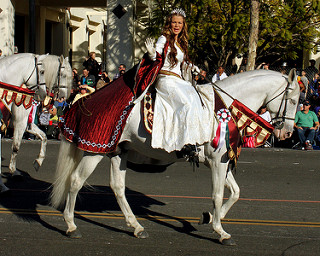

In [26]:
# to display the image
PIL.Image.open(str(roses[44]))

In [27]:
# we will create a dictionary of all the flowers and their coressponding image paths and also of labels
flower_images_dic = {
                      'roses'      : list(data_dir.glob('roses/*')),
                      'daisy'      : list(data_dir.glob('daisy/*')),
                      'dandelion'  : list(data_dir.glob('dandelion/*')),
                      'sunflowers' : list(data_dir.glob('sunflowers/*')),
                      'tulips'     : list(data_dir.glob('tulips/*')),
                    }
flower_labels_dic = {
                      'roses'      : 0,
                      'daisy'      : 1,
                      'dandelion'  : 2,
                      'sunflowers' : 3,
                      'tulips'     : 4,
                    }

#### We now use cv2
1. to read images from files.
2. Resize the images, as the images we have are not of a uniform size.

In [28]:
img = cv2.imread( str(flower_images_dic['roses'][0]) )
img.shape
# imread is used for reading images from files. It takes a file path as an argument,
# loads the image at that path, and returns it as a NumPy array.

(240, 179, 3)

In [29]:
cv2.resize(img, (200,200)).shape

(200, 200, 3)

In [30]:
# The above was a demonstration on one image, now we convert all the images into uniform size


##### Convert all the resized-images into array

In [31]:
inputs , targets = [], []
img_height, img_width = 360,270
for flower_name, images_dir in flower_images_dic.items():   # loop 1
    for image in images_dir:                                # loop 2
        img = cv2.imread( str(image) )                      # line 1
        resized_img = cv2.resize(img,(270,360))             # line 2
        inputs.append(resized_img)
        targets.append(flower_labels_dic[flower_name])      # line 3

#### Explaination of the code:
1. loop 1 iterates over the flowers and their respective pathlib, so total 5 iterations here.
2. loop 2 - from many image directories of one flower, it iterates over all the images present in that flower.
3. line 1 - convert pathlib into array.i.e. read image from files
4. line 2 - the array is resized such that all images have uniform size.
- the numbers:270,360 - I obtained them by iterating over the whole dataset, and finding average values of width and heigth.
5. line 3 - from 'flower_name' we get it's respective label from 'flower_labels_dic' which is then appended to 'targets'

In [32]:
# For consistency and efficiency of our code we convert these array into numpy array
inputs = np.array(inputs)
targets = np.array(targets)

#### Split the data

In [33]:
from sklearn.model_selection import train_test_split

train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, random_state=42)

#### Scale the inputs

In [34]:
train_inputs = train_inputs/255
test_inputs = test_inputs/255

#### Padding:
1. 'valid' (No Padding):

- In this type of padding, no extra padding is added to the input image before applying the convolution operation.
- As a result, the output size decreases with each convolutional layer because the filter cannot extend beyond the input boundaries.
- It's suitable when you want to reduce the spatial dimensions of the feature maps as you go deeper into the network.
2. 'same' (Zero Padding):

- In 'same' padding, zero-padding is added to the input image to ensure that the output size remains the same as the input size.
- Padding is added equally to all sides of the input to make the convolution operation symmetric.
- It's useful when you want to maintain the spatial dimensions of the feature maps, especially if you're concerned about losing spatial information.

### The Model

In [35]:
model = tf.keras.Sequential([
                                # cnn network
                                tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
                                tf.keras.layers.MaxPooling2D(),
                                tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
                                tf.keras.layers.MaxPooling2D(),
                                tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
                                tf.keras.layers.MaxPooling2D(),

                                # dense network, this accepts single dimention array so we flatten it.
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(64, activation= 'relu'),
                                tf.keras.layers.Dense(5,activation = 'softmax')

                            ])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy'
              )

model.fit(train_inputs,
          train_targets,
          epochs = 10,
          verbose = 2)


Epoch 1/10
86/86 - 47s - loss: 1.3981 - accuracy: 0.4128 - 47s/epoch - 551ms/step
Epoch 2/10
86/86 - 44s - loss: 1.0184 - accuracy: 0.5927 - 44s/epoch - 506ms/step
Epoch 3/10
86/86 - 41s - loss: 0.7979 - accuracy: 0.6995 - 41s/epoch - 471ms/step
Epoch 4/10
86/86 - 40s - loss: 0.5394 - accuracy: 0.8045 - 40s/epoch - 467ms/step
Epoch 5/10
86/86 - 41s - loss: 0.2814 - accuracy: 0.8964 - 41s/epoch - 471ms/step
Epoch 6/10
86/86 - 41s - loss: 0.1420 - accuracy: 0.9560 - 41s/epoch - 481ms/step
Epoch 7/10
86/86 - 41s - loss: 0.0673 - accuracy: 0.9818 - 41s/epoch - 480ms/step
Epoch 8/10
86/86 - 40s - loss: 0.0315 - accuracy: 0.9938 - 40s/epoch - 464ms/step
Epoch 9/10
86/86 - 40s - loss: 0.0365 - accuracy: 0.9887 - 40s/epoch - 469ms/step
Epoch 10/10
86/86 - 40s - loss: 0.0234 - accuracy: 0.9945 - 40s/epoch - 462ms/step


### note:
1. We got validation accuracy of 98 %, but after testing it on the test data, the accuracy is 60%. Hence our model has overfitted the training data.
2. To avoid this we use data augmentation.

In [36]:
model.evaluate(test_inputs, test_targets)

29/29 [==============================] - 4s 142ms/step - loss: 2.4864 - accuracy: 0.6166


[2.4864044189453125, 0.6165577173233032]

### Data Augmentation
1. Data augmentation is a technique used to artificially increase the size of a dataset by applying various transformations to the existing data samples. These transformations create new, slightly modified versions of the original data points.
2.  Data augmentation is primarily used to improve the generalization and robustness of machine learning models. It helps prevent overfitting and makes models more capable of handling variations and noise in real-world data.
3. Common Transformations:
- Image Data: Rotation, translation, scaling, flipping, brightness/contrast adjustments, cropping, and noise addition.
- Text Data: Synonym replacement, shuffling words, adding or removing words, and paraphrasing.
- Audio Data: Time stretching, pitch shifting, and background noise addition.

#### Explaination of the below code:
1. RandomFlip:
-  "horizontal" flipping- the image is mirrored along the vertical axis.
-  3 represent number of color channels.
2. RandomRotation:
-  argument specifies the maximum rotation angle in radians, here we allow rotations upto 0.5 radians in either direction.
3. RandomZoom:
-  argument specifies maximum zoom factor, here we allow zooming in or out by upto 50%.  

In [37]:
data_augumentation = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip(
                                                                    "horizontal",
                                                                    input_shape = (img_height,img_width,3)
                                                                 ),
                                             
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.5),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.5),                                                   
            ])

In [38]:
model = tf.keras.Sequential([
                                # cnn network
                                data_augumentation,
                                tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
                                tf.keras.layers.MaxPooling2D(),
                                tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
                                tf.keras.layers.MaxPooling2D(),
                                tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
                                tf.keras.layers.MaxPooling2D(),
                                tf.keras.layers.Dropout(0.2),

                                # dense network, this accepts single dimention array so we flatten it.
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(127, activation= 'relu'),
                                tf.keras.layers.Dense(5,activation = 'softmax')

                            ])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy'
              )

model.fit(train_inputs,
          train_targets,
          epochs = 30,
          validation_split= 0.2,
          verbose = 2)

Epoch 1/30
69/69 - 65s - loss: 1.5148 - accuracy: 0.3925 - val_loss: 1.1715 - val_accuracy: 0.4791 - 65s/epoch - 937ms/step
Epoch 2/30
69/69 - 48s - loss: 1.1948 - accuracy: 0.4998 - val_loss: 1.0873 - val_accuracy: 0.5408 - 48s/epoch - 696ms/step
Epoch 3/30
69/69 - 47s - loss: 1.1020 - accuracy: 0.5516 - val_loss: 1.0354 - val_accuracy: 0.5844 - 47s/epoch - 685ms/step
Epoch 4/30
69/69 - 48s - loss: 1.0212 - accuracy: 0.5861 - val_loss: 1.0002 - val_accuracy: 0.5808 - 48s/epoch - 696ms/step
Epoch 5/30
69/69 - 48s - loss: 0.9642 - accuracy: 0.6247 - val_loss: 0.9728 - val_accuracy: 0.6134 - 48s/epoch - 692ms/step
Epoch 6/30
69/69 - 47s - loss: 0.9568 - accuracy: 0.6315 - val_loss: 0.9696 - val_accuracy: 0.6225 - 47s/epoch - 686ms/step
Epoch 7/30
69/69 - 46s - loss: 0.9188 - accuracy: 0.6479 - val_loss: 0.9390 - val_accuracy: 0.6098 - 46s/epoch - 671ms/step
Epoch 8/30
69/69 - 47s - loss: 0.8943 - accuracy: 0.6538 - val_loss: 0.9304 - val_accuracy: 0.6334 - 47s/epoch - 684ms/step
Epoch 9/

In [39]:
model.evaluate(test_inputs,test_targets)

29/29 [==============================] - 3s 116ms/step - loss: 0.7351 - accuracy: 0.7113


[0.7350955605506897, 0.7113289833068848]

### Conclusion
 We had validation accuracy of 70% and we got test accuracy of 71%, hence our model did not overfit the data.

We will try to improve this accuracy by transfer learning in the next project